# Run Any Kind of Logistic Regression (Binomial, Multinomial, etc.)

### Authors: Calvin Howard.

#### Last updated: March 16, 2024

Use this to run/test a statistical model on a spreadsheet.

Notes:
- To best use this notebook, you should be familar with GLM design and Contrast Matrix design. See this webpage to get started:
[FSL's GLM page](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/GLM)

# 00 - Import CSV with All Data
**The CSV is expected to be in this format**
- ID and absolute paths to niftis are critical
```
+-----+----------------------------+--------------+--------------+--------------+
| ID  | Nifti_File_Path            | Covariate_1  | Covariate_2  | Covariate_3  |
+-----+----------------------------+--------------+--------------+--------------+
| 1   | /path/to/file1.nii.gz      | 0.5          | 1.2          | 3.4          |
| 2   | /path/to/file2.nii.gz      | 0.7          | 1.4          | 3.1          |
| 3   | /path/to/file3.nii.gz      | 0.6          | 1.5          | 3.5          |
| 4   | /path/to/file4.nii.gz      | 0.9          | 1.1          | 3.2          |
| ... | ...                        | ...          | ...          | ...          |
+-----+----------------------------+--------------+--------------+--------------+
```

Prep Output Directory

In [1]:
# Specify where you want to save your results to
out_dir = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/collaborations/barotono_disease_classification/metadata/dataset_7/cth_v7'

Import Data

In [2]:
# Specify the path to your CSV file containing NIFTI paths
input_csv_path = '/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/collaborations/barotono_disease_classification/metadata/dataset_7/cth_v7/differential_diagnoses_train_CT_april23.csv'
sheet = None

In [3]:
from calvin_utils.permutation_analysis_utils.statsmodels_palm import CalvinStatsmodelsPalm
# Instantiate the PalmPrepararation class
cal_palm = CalvinStatsmodelsPalm(input_csv_path=input_csv_path, output_dir=out_dir, sheet=sheet)
# Call the process_nifti_paths method
data_df = cal_palm.read_and_display_data()
data_df

,DX,subid,AD,SV,LBD,BV,PNFA,CBS,PSP,CN
0,AD,002_S_5018,0.792234,0.637130,0.770520,0.711657,0.741938,0.741759,0.751960,0.778796
1,AD,003_S_4136,0.698004,0.541441,0.697240,0.664413,0.627885,0.639614,0.655714,0.681190
2,AD,003_S_4152,0.710199,0.464189,0.721739,0.734623,0.733545,0.686729,0.699635,0.698206
3,AD,003_S_4373,0.742413,0.586996,0.689886,0.646002,0.718025,0.714775,0.692431,0.712252
4,AD,003_S_4892,0.787148,0.624036,0.770895,0.713148,0.747336,0.754323,0.751406,0.788459
...,...,...,...,...,...,...,...,...,...,...
472,CN,130_S_4343,0.820439,0.612870,0.817282,0.770483,0.803333,0.810117,0.813656,0.835698
473,CN,135_S_4566,0.801270,0.604334,0.753413,0.697122,0.760507,0.799688,0.779230,0.786925
474,CN,137_S_4520,0.828650,0.600227,0.836563,0.776609,0.810572,0.835810,0.830756,0.857019
475,CN,137_S_4632,0.820463,0.619128,0.834255,0.801400,0.808762,0.823134,0.830933,0.845885


# 01 - Preprocess Your Data

**Handle NANs**
- Set drop_nans=True is you would like to remove NaNs from data
- Provide a column name or a list of column names to remove NaNs from

In [4]:
drop_list = ['DX']

In [5]:
data_df = cal_palm.drop_nans_from_columns(columns_to_drop_from=drop_list)
display(data_df)

,DX,subid,AD,SV,LBD,BV,PNFA,CBS,PSP,CN
0,AD,002_S_5018,0.792234,0.637130,0.770520,0.711657,0.741938,0.741759,0.751960,0.778796
1,AD,003_S_4136,0.698004,0.541441,0.697240,0.664413,0.627885,0.639614,0.655714,0.681190
2,AD,003_S_4152,0.710199,0.464189,0.721739,0.734623,0.733545,0.686729,0.699635,0.698206
3,AD,003_S_4373,0.742413,0.586996,0.689886,0.646002,0.718025,0.714775,0.692431,0.712252
4,AD,003_S_4892,0.787148,0.624036,0.770895,0.713148,0.747336,0.754323,0.751406,0.788459
...,...,...,...,...,...,...,...,...,...,...
472,CN,130_S_4343,0.820439,0.612870,0.817282,0.770483,0.803333,0.810117,0.813656,0.835698
473,CN,135_S_4566,0.801270,0.604334,0.753413,0.697122,0.760507,0.799688,0.779230,0.786925
474,CN,137_S_4520,0.828650,0.600227,0.836563,0.776609,0.810572,0.835810,0.830756,0.857019
475,CN,137_S_4632,0.820463,0.619128,0.834255,0.801400,0.808762,0.823134,0.830933,0.845885


**Drop Row Based on Value of Column**

Define the column, condition, and value for dropping rows
- column = 'your_column_name'
- condition = 'above'  # Options: 'equal', 'above', 'below'

In [6]:
data_df.columns

Index(['DX', 'subid', 'AD', 'SV', 'LBD', 'BV', 'PNFA', 'CBS', 'PSP', 'CN'], dtype='object')

Set the parameters for dropping rows

In [7]:
# column = 'Cohort'  # The column you'd like to evaluate
# condition = 'equal'  # The condition to check ('equal', 'above', 'below', 'not')
# value = 0 # The value to drop if found

In [8]:
# data_df, other_df = cal_palm.drop_rows_based_on_value(column, condition, value)
# display(data_df)

**Standardize Data**
- Enter Columns you Don't want to standardize into a list

In [9]:
# Remove anything you don't want to standardize
# cols_not_to_standardize = ['DX', 'SUBID'] # ['Z_Scored_Percent_Cognitive_Improvement_By_Origin_Group', 'Z_Scored_Subiculum_T_By_Origin_Group_'] #['Age']


In [10]:
# data_df = cal_palm.standardize_columns(cols_not_to_standardize)
# data_df

# 00 - Define Your Formula

This is the formula relating outcome to predictors, and takes the form:
- y = B0 + B1 + B2 + B3 + . . . BN

It is defined using the columns of your dataframe instead of the variables above:
- 'Apples_Picked ~ hours_worked + owns_apple_picking_machine'

____
**Normal Logistic**
- Assesses the impact of multiple predictors on an outcome.
- formula = 'Binary Outcome ~ Predictor1 + Predictor2'

**Multiple Logistic**
- Assesses the impact of predictor on an outcome.
- formula = 'Ordinal Outcome ~ Predictor1 + Predictor2'

____
Use the printout below to design your formula. 
- Left of the "~" symbol is the thing to be predicted. 
- Right of the "~" symbol are the predictors. 
- ":" indicates an interaction between two things. 
- "*" indicates and interactions AND it accounts for the simple effects too. 
- "+" indicates that you want to add another predictor. 

In [11]:
data_df.columns

Index(['DX', 'subid', 'AD', 'SV', 'LBD', 'BV', 'PNFA', 'CBS', 'PSP', 'CN'], dtype='object')

In [12]:
formula = "DX ~ AD + SV + LBD + BV + PNFA + CBS + PSP + CN"

# 02 - Visualize Your Design Matrix

This is the explanatory variable half of your regression formula
_______________________________________________________
Create Design Matrix: Use the create_design_matrix method. You can provide a list of formula variables which correspond to column names in your dataframe.

- design_matrix = palm.create_design_matrix(formula_vars=["var1", "var2", "var1*var2"])
- To include interaction terms, use * between variables, like "var1*var2".
- By default, an intercept will be added unless you set intercept=False
- **don't explicitly add the 'intercept' column. I'll do it for you.**

In [13]:
# Define the design matrix
outcome_matrix, design_matrix = cal_palm.define_design_matrix(formula, data_df, add_intercept=False)
design_matrix

,AD,SV,LBD,BV,PNFA,CBS,PSP,CN
0,0.792234,0.637130,0.770520,0.711657,0.741938,0.741759,0.751960,0.778796
1,0.698004,0.541441,0.697240,0.664413,0.627885,0.639614,0.655714,0.681190
2,0.710199,0.464189,0.721739,0.734623,0.733545,0.686729,0.699635,0.698206
3,0.742413,0.586996,0.689886,0.646002,0.718025,0.714775,0.692431,0.712252
4,0.787148,0.624036,0.770895,0.713148,0.747336,0.754323,0.751406,0.788459
...,...,...,...,...,...,...,...,...
472,0.820439,0.612870,0.817282,0.770483,0.803333,0.810117,0.813656,0.835698
473,0.801270,0.604334,0.753413,0.697122,0.760507,0.799688,0.779230,0.786925
474,0.828650,0.600227,0.836563,0.776609,0.810572,0.835810,0.830756,0.857019
475,0.820463,0.619128,0.834255,0.801400,0.808762,0.823134,0.830933,0.845885


Check multicollinearity in design matrix

In [14]:
#Multico. Check
from calvin_utils.statistical_utils.statistical_measurements import calculate_vif
calculate_vif(design_matrix)

,features,VIF
0,AD,3777.566376
1,SV,155.518703
2,LBD,7271.510070
3,BV,1873.457247
4,PNFA,3726.821407
5,CBS,15209.136788
6,PSP,17606.890279
7,CN,9960.666875


# 03 - Visualize Your Dependent Variable

I have generated this for you based on the formula you provided

In [15]:
# outcome_matrix = outcome_matrix.iloc[:, [0]]
outcome_matrix

,DX[AD],DX[BV],DX[CBS],DX[CN],DX[LBD],DX[PNFA],DX[PSP],DX[SV]
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
472,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
473,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
474,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
475,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


**CRITICAL IN MULTINOMIAL LOGISTIC REGRESSION**
- A multinomial logistic reg. will set results RELATIVE TO A REFERENCE class. 
- The reference class is the first classification the multinomial encounters.
- **Especially if you are running a multinomial logistic regression, set your reference class below**

In [16]:
reference = 'Diagnosis[Control]'

# 04 - Run the Regression

Regression Results Are Displayed Below

- This will run a binomial or a multinomial logit dependig on your outcome matrix. 
- A multinomial logit will display N-1 categories, where N is the number of potential classifications you have. This occurs because everything is set in reference to that class. 
- So, the reference will either be the first column in your outcomes_matrix, or you can manually set it first.

In [17]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import pandas as pd

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(design_matrix)

# Train SVM
y = outcome_matrix.idxmax(axis=1)
svm = SVC(probability=True, kernel='linear', random_state=42)
svm.fit(X_scaled, y)

# Predict probabilities on training data
probabilities = svm.predict_proba(X_scaled)
predictions_df = pd.DataFrame(probabilities, columns=svm.classes_)

# Output
print(predictions_df)

# Optional: evaluate performance on training data
y_pred = svm.predict(X_scaled)
print(classification_report(y, y_pred))


       DX[AD]    DX[BV]   DX[CBS]    DX[CN]   DX[LBD]  DX[PNFA]   DX[PSP]  \
0    0.775115  0.011768  0.003899  0.137290  0.046584  0.007356  0.012244   
1    0.773702  0.054207  0.002242  0.037694  0.116261  0.003668  0.006898   
2    0.135446  0.537122  0.014273  0.028566  0.106481  0.142255  0.029725   
3    0.827170  0.030646  0.009667  0.037717  0.014364  0.059324  0.013304   
4    0.599176  0.012722  0.007390  0.300293  0.045045  0.010586  0.019718   
..        ...       ...       ...       ...       ...       ...       ...   
472  0.130477  0.016391  0.037866  0.660862  0.060144  0.025774  0.064738   
473  0.368280  0.009634  0.088169  0.420256  0.017922  0.030191  0.060134   
474  0.039511  0.007440  0.059070  0.759566  0.046805  0.012150  0.073151   
475  0.060993  0.023832  0.040724  0.673223  0.079142  0.027932  0.089698   
476  0.107976  0.015339  0.042092  0.690178  0.044809  0.030543  0.065392   

       DX[SV]  
0    0.005744  
1    0.005329  
2    0.006131  
3    0.0078

In [18]:
# from calvin_utils.statistical_utils.logistic_regression import LogisticRegression
# logreg = LogisticRegression(outcome_matrix, design_matrix)
# results = logreg.run()
# results.summary2()

# 6 - Receiver Operating Characteristic
- The ROC considers clasisfications acoss ALL POSSIBLE PROBABILITIES, demonstrating what is ultiamtely accomplishable at the best possible threshold

- First curve is ROC for classifcation of each class with respect to all other classes
- Second Curve (Macro Average) is basically a meta-analytic ROC with equal weight per class.
- Third Curve (Micro Average) is basically a meta-analytic ROC with weight proportional to class sample

Taking maximum probability as prediction.
There are 112.0 observations for DX[AD]
There are 45.0 observations for DX[BV]
There are 31.0 observations for DX[CBS]
There are 170.0 observations for DX[CN]
There are 30.0 observations for DX[LBD]
There are 28.0 observations for DX[PNFA]
There are 32.0 observations for DX[PSP]
There are 29.0 observations for DX[SV]


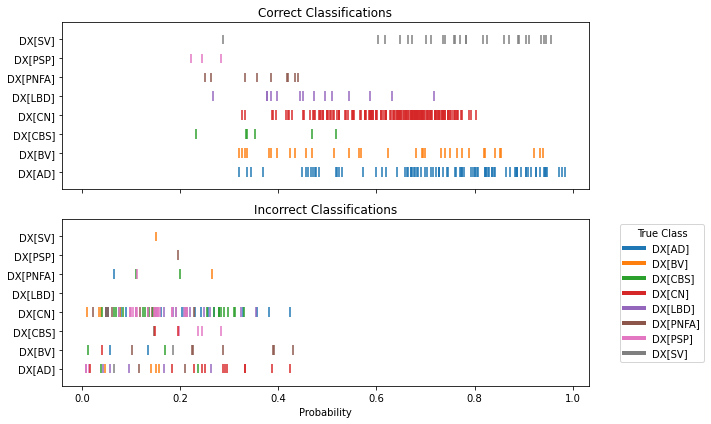

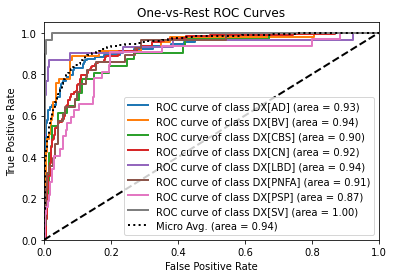

Optimal Thresholds: 
 {0: 0.22951705458297814, 1: 0.14089593738362804, 2: 0.12427886271500885, 3: 0.4165405214815959, 4: 0.14751144896888865, 5: 0.10194031605748025, 6: 0.09856141157864895, 7: 0.06607372839689088}


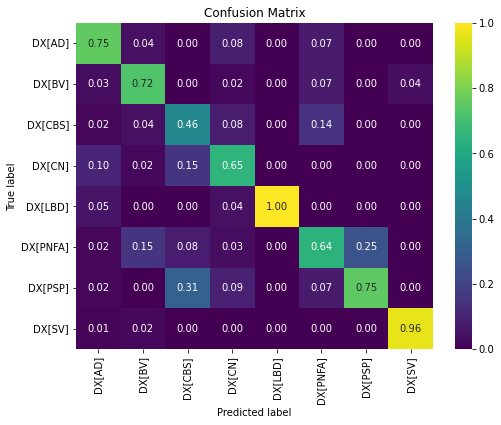

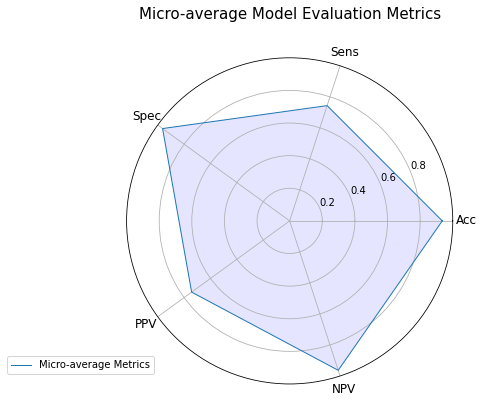

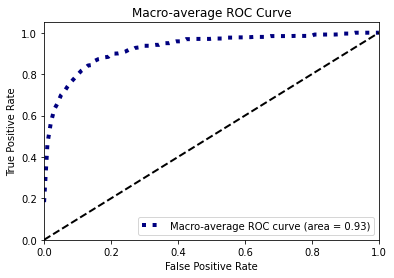

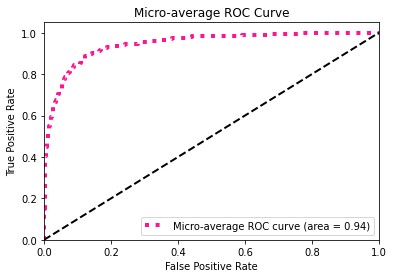

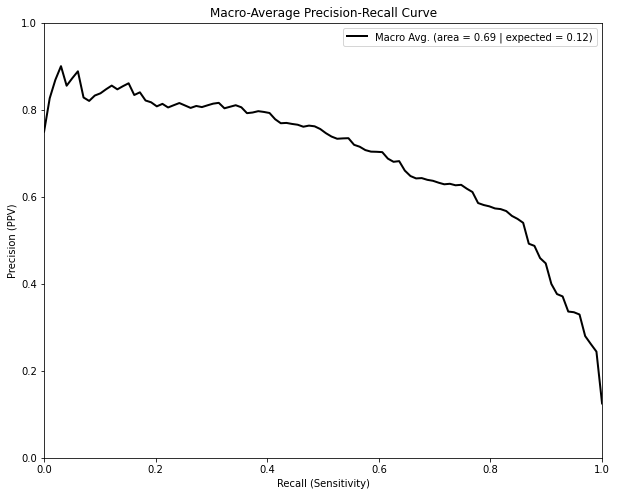

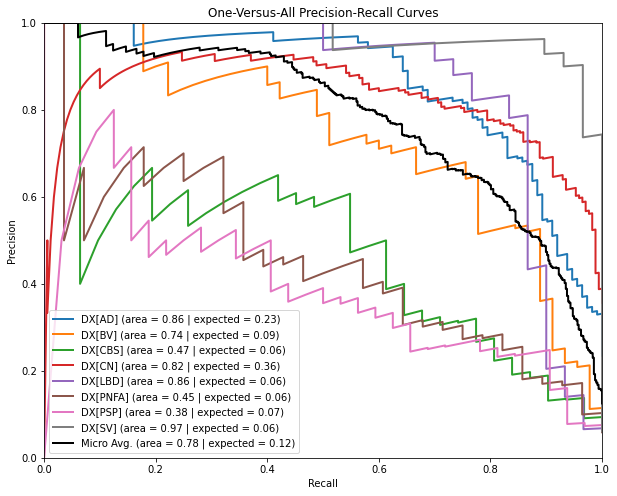

In [19]:
from calvin_utils.statistical_utils.classification_statistics import ComprehensiveMulticlassROC
evaluator = ComprehensiveMulticlassROC(fitted_model=None, predictions_df=predictions_df, observation_df=outcome_matrix, normalization='pred', thresholds=None, out_dir=out_dir+'/train_results')
evaluator.run()

Visuialize OVR CIs

Done  DX[AD]
Done  DX[BV]
Done  DX[CBS]
Done  DX[CN]
Done  DX[LBD]
Done  DX[PNFA]
Done  DX[PSP]
Done  DX[SV]


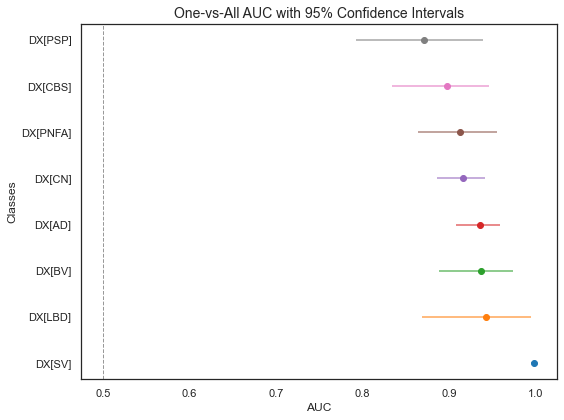

In [20]:
df, bootstrap  = evaluator.bootstrap_ovr_auroc(raw_observations=evaluator.raw_observations, raw_predictions=evaluator.raw_predictions, outcome_matrix_cols=evaluator.outcome_matrix.columns)
ComprehensiveMulticlassROC.plot_ovr_auc_with_ci(df, out_dir=out_dir+'/train_auc_per_diagnosis')

ADVANCED
- code specific manual thresholds to intervene upon classifications

Step 1: relate integer (index) to class

In [21]:
# evaluator.relate_index_to_class()

Step 2: in a dictionary of the indices (corresponding to class), key in the lambda function to edit the probability. 
- Code from left to right, giving priority to each method. 
- Example:
```
>thresholds = {
>            0: lambda probs: 0 if probs[0] > 0.5 else (1 if probs[0] > 0.25 else 2),  # Adjust class_0 predictions
>            1: lambda probs: None,  # No threshold adjustment for class_1
>            2: lambda probs: None   # No threshold adjustment for class_2
>        }
```

In [22]:
# thresholds = {
#     0: lambda prob: 0,  # Always keep class 0
#     1: lambda prob: 1,  # Always keep class 1
#     2: lambda prob: 2 if prob[2] > 0.5 else (1 if prob[1] > 0.3 else 0)  # Conditional adjustment for class 2
# }


Step 3: Check the effect

In [23]:
# from calvin_utils.statistical_utils.classification_statistics import ComprehensiveMulticlassROC
# evaluator = ComprehensiveMulticlassROC(fitted_model=results, observation_df=outcome_matrix, normalization='pred', thresholds=thresholds, out_dir=out_dir)
# evaluator.run()

Step 4: YOU MUST LOOCV AND VALIDATE IN OUT-OF-SAMPLE DATA.
- add thresholds as an argument to any further calls to ComprehensiveMulticlassROC

Bootstrap the Micro Average AUC

In [24]:
design_matrix

,AD,SV,LBD,BV,PNFA,CBS,PSP,CN
0,0.792234,0.637130,0.770520,0.711657,0.741938,0.741759,0.751960,0.778796
1,0.698004,0.541441,0.697240,0.664413,0.627885,0.639614,0.655714,0.681190
2,0.710199,0.464189,0.721739,0.734623,0.733545,0.686729,0.699635,0.698206
3,0.742413,0.586996,0.689886,0.646002,0.718025,0.714775,0.692431,0.712252
4,0.787148,0.624036,0.770895,0.713148,0.747336,0.754323,0.751406,0.788459
...,...,...,...,...,...,...,...,...
472,0.820439,0.612870,0.817282,0.770483,0.803333,0.810117,0.813656,0.835698
473,0.801270,0.604334,0.753413,0.697122,0.760507,0.799688,0.779230,0.786925
474,0.828650,0.600227,0.836563,0.776609,0.810572,0.835810,0.830756,0.857019
475,0.820463,0.619128,0.834255,0.801400,0.808762,0.823134,0.830933,0.845885


In [ ]:
import matplotlib
from calvin_utils.statistical_utils.classification_statistics import bootstrap_auc
matplotlib.use('Agg')  # Use a non-interactive backend

mean_auc, lower_ci, upper_ci = bootstrap_auc(outcome_matrix, design_matrix, n_iterations=1000)
print(f'Mean AUC: {mean_auc}, 95% CI: ({lower_ci}, {upper_ci})')

Permutation Test Two Different Formulas by Comparing Their AUCs

In [ ]:
data_df.columns

In [ ]:
# f1 = "Diagnosis ~ CerebellumCSF + ParietalCSF + MTLCSF + OccipitalCSF + FrontalCSF + temp_ins_csf + SubcortexCSF"
# f2 = "Diagnosis ~ CerebellumGM + ParietalGM + MTLGM + OccipitalGM + FrontalGM + temp_ins_gm + SubcortexGM"

In [ ]:
# import matplotlib
# matplotlib.use('Agg')  # Use a non-interactive backend
# from calvin_utils.statistical_utils.classification_statistics import permute_auc_difference
# obs_diff, lower_ci, upper_ci, p_value = permute_auc_difference(data_df, formula1=f1, 
#                                                                   formula2=f2,
#                                                                   cal_palm=cal_palm, n_iterations=1000)
# print(f'Observde AUC Difference: {obs_diff}, 95% CI: ({lower_ci}, {upper_ci}), p-value: {p_value}')

# 06 - Visualize the Regression as a Forest Plot
- This will probably look poor if you ran a regression without standardizing your data. 

In [ ]:
from calvin_utils.statistical_utils.statistical_measurements import MultinomialForestPlot

multinomial_forest = MultinomialForestPlot(model=results, sig_digits=2, out_dir=out_dir+'/forest_plots', table=False)
multinomial_forest.run()

# 07 - Generate Partial Dependence Plots

In [ ]:
from calvin_utils.statistical_utils.statistical_measurements import PartialDependencePlot
pdp = PartialDependencePlot(formula=formula, data_df=data_df, model=results, design_matrix=design_matrix, outcomes_df=outcome_matrix, data_range=[-1,1], out_dir=out_dir+'/partial_dep_plots', marginal_method='mean', debug=False)
pdp.run()

# 08 - Visualize the Partial Regression Plots

In [ ]:
from calvin_utils.statistical_utils.statistical_measurements import PartialRegressionPlot
partial_plot = PartialRegressionPlot(model=results, design_matrix=design_matrix, out_dir=out_dir+'/partial_regression_plot', palette=None)
partial_plot = partial_plot.run()

# 09 - LOOCV

477it [00:09, 52.56it/s]


Taking maximum probability as prediction.
There are 112.0 observations for DX[AD]
There are 45.0 observations for DX[BV]
There are 31.0 observations for DX[CBS]
There are 170.0 observations for DX[CN]
There are 30.0 observations for DX[LBD]
There are 28.0 observations for DX[PNFA]
There are 32.0 observations for DX[PSP]
There are 29.0 observations for DX[SV]


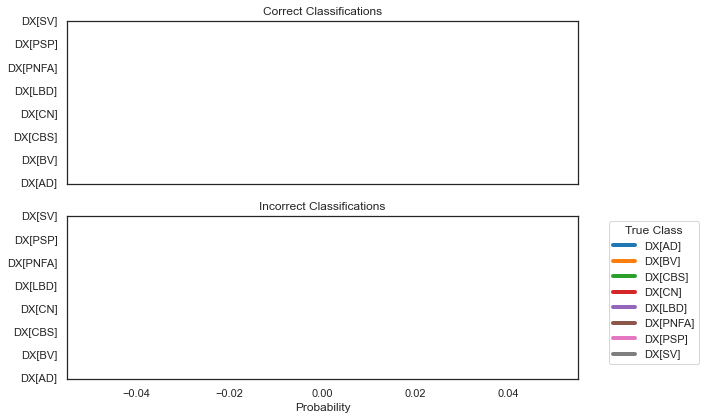

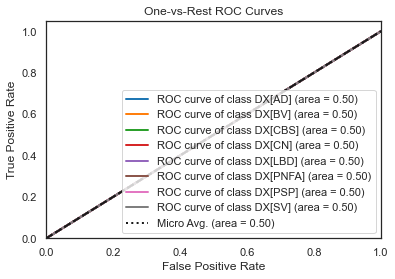

Optimal Thresholds: 
 {0: inf, 1: inf, 2: inf, 3: inf, 4: inf, 5: inf, 6: inf, 7: inf}


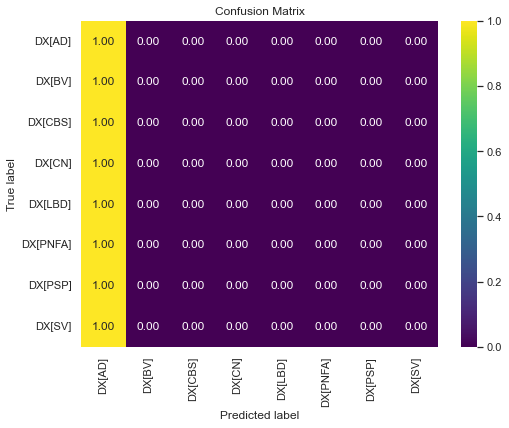

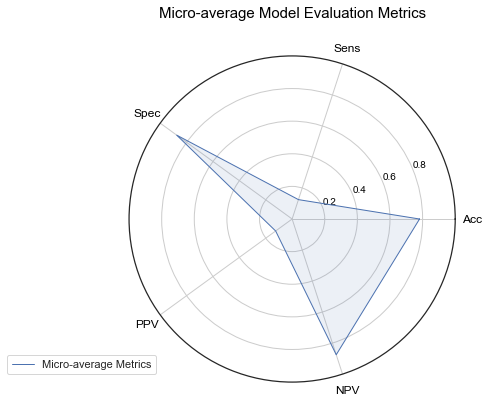

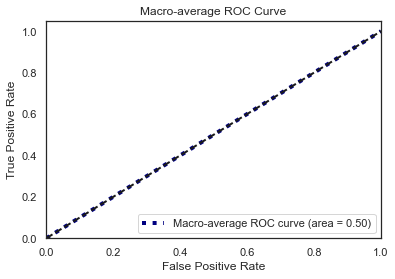

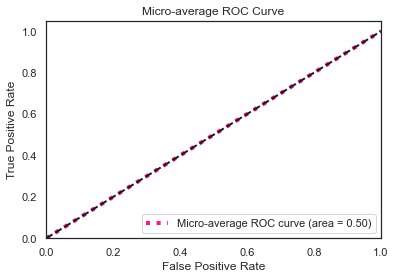

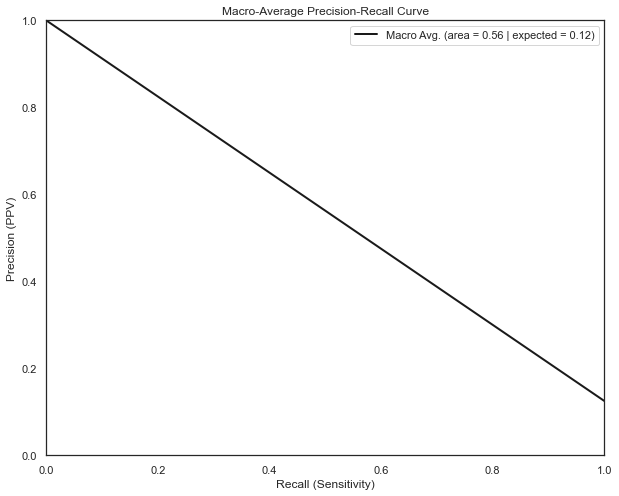

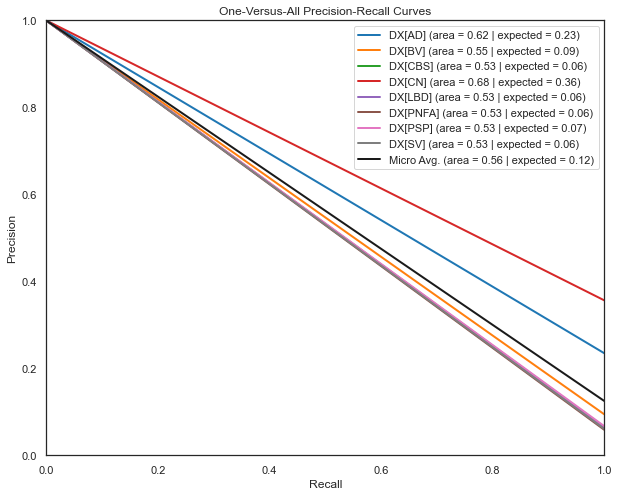

In [25]:
import pandas as pd
from calvin_utils.statistical_utils.logistic_regression import LogisticRegression
from calvin_utils.statistical_utils.classification_statistics import ComprehensiveMulticlassROC
y_true, y_pred, test_prob = LogisticRegression.run_loocv(outcome_matrix, design_matrix)
loocv_evaluator = ComprehensiveMulticlassROC(fitted_model=None, predictions_df=pd.DataFrame(design_matrix, columns=outcome_matrix.columns), observation_df=outcome_matrix, normalization='true', thresholds=None, out_dir=out_dir+'/loocv_results')
loocv_evaluator.run()

Done  DX[AD]
Done  DX[BV]
Done  DX[CBS]
Done  DX[CN]
Done  DX[LBD]
Done  DX[PNFA]
Done  DX[PSP]
Done  DX[SV]


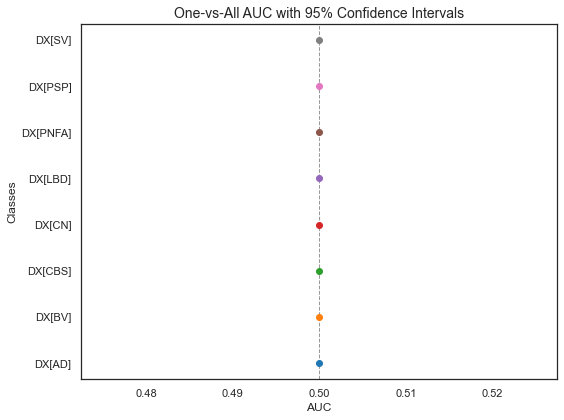

In [26]:
df, bootstrap  = loocv_evaluator.bootstrap_ovr_auroc(raw_observations=loocv_evaluator.raw_observations, raw_predictions=loocv_evaluator.raw_predictions, outcome_matrix_cols=loocv_evaluator.outcome_matrix.columns)
ComprehensiveMulticlassROC.plot_ovr_auc_with_ci(df, out_dir=out_dir+'/loocv_auc_per_diagnosis')

# 10 - Predict Unseen Data
- Unseen data is expected to be in a held-out CSV with the exact same naming conventions used by the training data

In [27]:
new_csv_path='/Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/collaborations/barotono_disease_classification/metadata/dataset_7/cth_v7/differential_diagnoses_test_CT_april23.csv'

Get New Data

In [28]:
from calvin_utils.permutation_analysis_utils.statsmodels_palm import CalvinStatsmodelsPalm
# # Instantiate the PalmPrepararation class
new_palm = CalvinStatsmodelsPalm(input_csv_path=new_csv_path, output_dir=out_dir+'/test_results', sheet=sheet)
# Call the process_nifti_paths method
other_df = new_palm.read_and_display_data()
other_df

,DX,subid,AD,SV,LBD,BV,PNFA,CBS,PSP,CN
0,AD,003_S_5187,0.796418,0.543939,0.772976,0.725057,0.768702,0.796617,0.780774,0.793734
1,AD,005_S_5119,0.793366,0.632136,0.758798,0.725350,0.723419,0.729251,0.739080,0.764640
2,AD,006_S_4153,0.762343,0.686035,0.699210,0.635077,0.674810,0.686502,0.672871,0.725004
3,AD,009_S_5037,0.799139,0.637141,0.782522,0.730259,0.749565,0.762866,0.770673,0.788059
4,AD,009_S_5252,0.775327,0.549769,0.774576,0.758830,0.751912,0.754455,0.765437,0.777900
...,...,...,...,...,...,...,...,...,...,...
117,CN,1_S_0287,0.812171,0.618539,0.810276,0.769580,0.793029,0.806763,0.817710,0.833011
118,CN,1_S_0299,0.840876,0.629308,0.846597,0.791089,0.831633,0.844472,0.840352,0.857913
119,CN,1_S_0329,0.781305,0.582989,0.778777,0.768632,0.782717,0.787656,0.791669,0.793728
120,CN,136_S_4433,0.840201,0.618135,0.826548,0.767295,0.800336,0.828521,0.821508,0.849225


Prepare Data

In [29]:
# Define the design matrix
# subset_df = other_df.groupby('DIAGNOSIS_BL').apply(lambda x: x.sample(min(len(x), 200))).reset_index(drop=True)
import pandas as pd
other_outcome_matrix, other_design_matrix = new_palm.define_design_matrix(formula, other_df, add_intercept=False)

# Ensure both matrices have the same columns
if len(other_outcome_matrix.columns) != len(outcome_matrix.columns):
    # Create a zero-filled DataFrame with the same columns as outcome_matrix
    zero_df = pd.DataFrame(0, index=other_outcome_matrix.index, columns=outcome_matrix.columns)
    
    # Fill zero_df with values from other_outcome_matrix where columns exist
    common_columns = other_outcome_matrix.columns.intersection(outcome_matrix.columns)
    zero_df.loc[:, common_columns] = other_outcome_matrix.loc[:, common_columns]
    
    other_outcome_matrix = zero_df

other_design_matrix

,AD,SV,LBD,BV,PNFA,CBS,PSP,CN
0,0.796418,0.543939,0.772976,0.725057,0.768702,0.796617,0.780774,0.793734
1,0.793366,0.632136,0.758798,0.725350,0.723419,0.729251,0.739080,0.764640
2,0.762343,0.686035,0.699210,0.635077,0.674810,0.686502,0.672871,0.725004
3,0.799139,0.637141,0.782522,0.730259,0.749565,0.762866,0.770673,0.788059
4,0.775327,0.549769,0.774576,0.758830,0.751912,0.754455,0.765437,0.777900
...,...,...,...,...,...,...,...,...
117,0.812171,0.618539,0.810276,0.769580,0.793029,0.806763,0.817710,0.833011
118,0.840876,0.629308,0.846597,0.791089,0.831633,0.844472,0.840352,0.857913
119,0.781305,0.582989,0.778777,0.768632,0.782717,0.787656,0.791669,0.793728
120,0.840201,0.618135,0.826548,0.767295,0.800336,0.828521,0.821508,0.849225


Predict

Evaluate

In [30]:
formula

'DX ~ AD + SV + LBD + BV + PNFA + CBS + PSP + CN'

In [31]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Standardize features
scaler = StandardScaler()
testX_scaled = scaler.fit_transform(other_design_matrix)

probabilities = svm.predict_proba(testX_scaled)
predictions_df = pd.DataFrame(probabilities)

In [32]:
# thresholds = {
#     0: lambda prob: 0 if prob < 0.33 else 1,
#     1: lambda prob: 1 if prob > 0.33 else 0
# }

Taking maximum probability as prediction.
There are 28.0 observations for DX[AD]
There are 12.0 observations for DX[BV]
There are 8.0 observations for DX[CBS]
There are 41.0 observations for DX[CN]
There are 8.0 observations for DX[LBD]
There are 8.0 observations for DX[PNFA]
There are 9.0 observations for DX[PSP]
There are 8.0 observations for DX[SV]


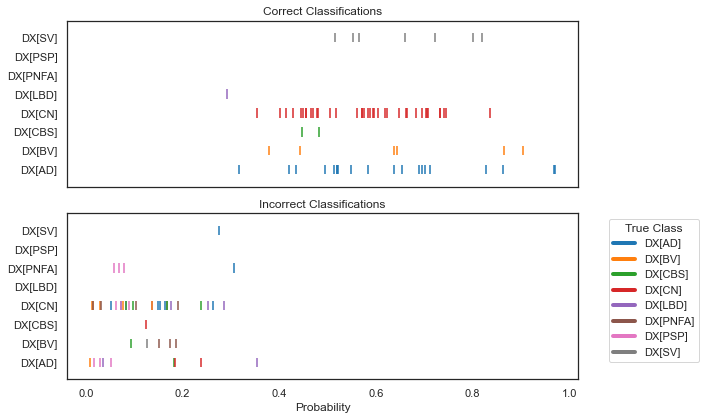

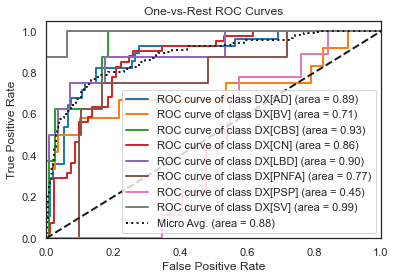

Optimal Thresholds: 
 {0: 0.2624399415687218, 1: 0.13788230672522858, 2: 0.0831577194847753, 3: 0.401201572340124, 4: 0.08369711850814995, 5: 0.10336461162266221, 6: 0.05145608552925677, 7: 0.12680933967188465}


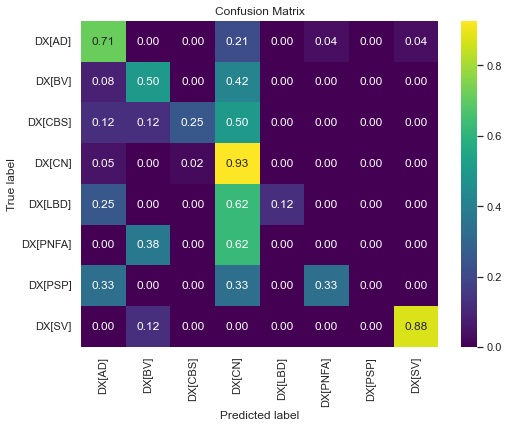

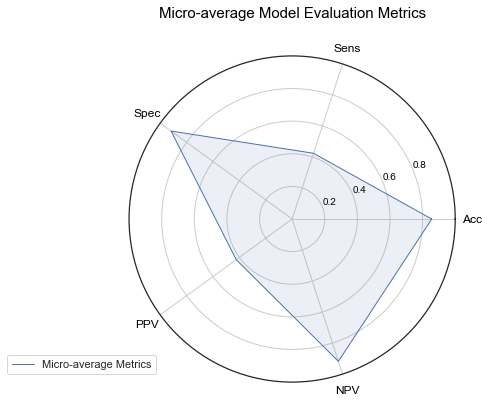

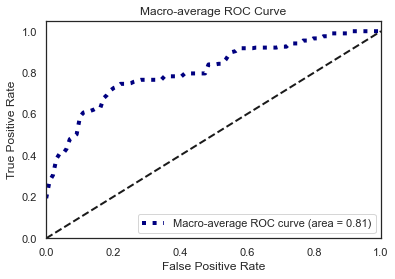

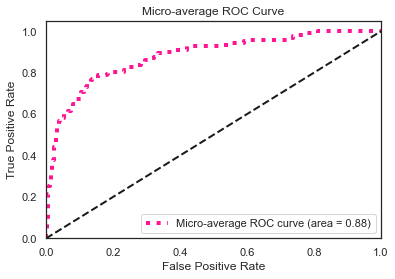

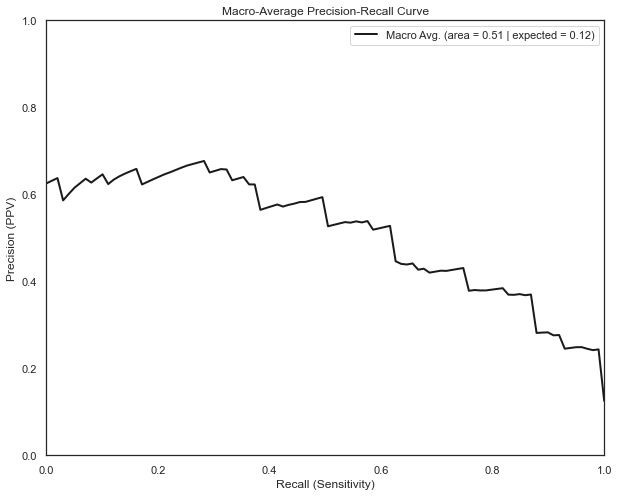

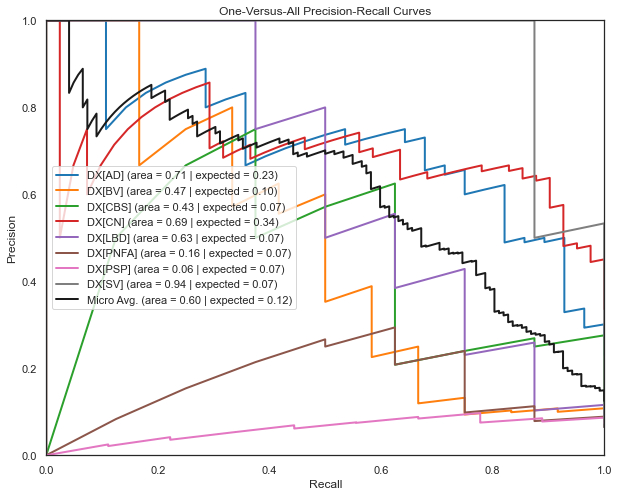

In [33]:
from calvin_utils.statistical_utils.classification_statistics import ComprehensiveMulticlassROC
loocv_evaluator = ComprehensiveMulticlassROC(fitted_model=None, predictions_df=predictions_df, observation_df=other_outcome_matrix, normalization='true', thresholds=None, out_dir=out_dir+'/test_results')
loocv_evaluator.run() 

In [34]:
loocv_evaluator.save_dataframes()

Saved predicted probabilities to CSV files at:  /Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/collaborations/barotono_disease_classification/metadata/dataset_7/cth_v7/test_results as predicted_probabilities.csv
and
Saved observed labels to CSV files at:  /Users/cu135/Partners HealthCare Dropbox/Calvin Howard/studies/collaborations/barotono_disease_classification/metadata/dataset_7/cth_v7/test_results as observed_labels.csv


Get One Vs. All Confidence Intervals on AUC

Done  DX[AD]
Done  DX[BV]
Done  DX[CBS]
Done  DX[CN]
Done  DX[LBD]
Done  DX[PNFA]
Done  DX[PSP]
Done  DX[SV]


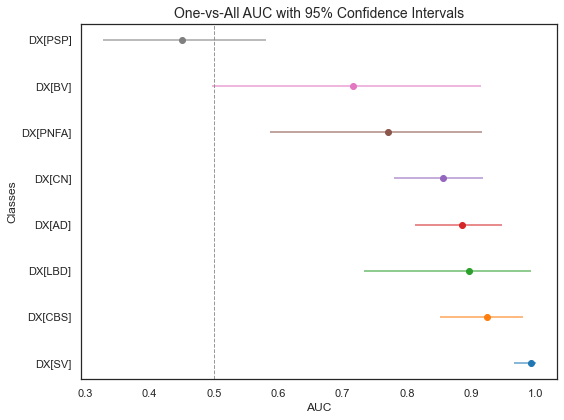

In [35]:
df, bootstrap = ComprehensiveMulticlassROC.bootstrap_ovr_auroc(raw_observations=loocv_evaluator.raw_observations, raw_predictions=loocv_evaluator.raw_predictions, outcome_matrix_cols=loocv_evaluator.outcome_matrix.columns)
ComprehensiveMulticlassROC.plot_ovr_auc_with_ci(df, out_dir=out_dir+'/test_auc_per_diagnosis')

In [36]:
display(df)

,Class,Mean AUROC,Std,lower_ci,upper_ci
0,DX[AD],0.886055,0.034974,0.811904,0.947363
1,DX[BV],0.716892,0.105943,0.498076,0.914484
2,DX[CBS],0.923736,0.033383,0.850893,0.980966
3,DX[CN],0.855889,0.035151,0.779816,0.917874
4,DX[LBD],0.897197,0.066546,0.733553,0.993169
5,DX[PNFA],0.770052,0.087449,0.586811,0.916674
6,DX[PSP],0.451116,0.065973,0.327682,0.581152
7,DX[SV],0.992138,0.009345,0.966460,1.000000


Get Confidence Intervals on Sensitivity, Specificity, NPV, PPV, and Accuracy for Each Class

--Optimal Threshold--
True Positives: 23
True Negatives: 80
False Positives: 14
False Negatives: 5


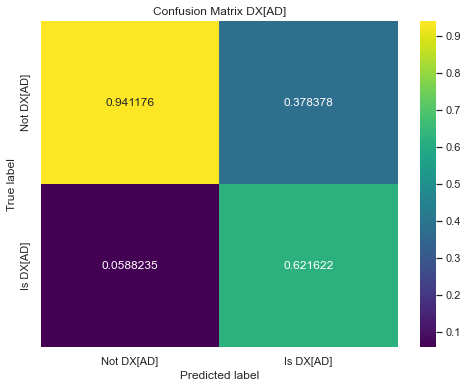

DX[AD]: 0.2624399415687218
True Positives: 7
True Negatives: 99
False Positives: 11
False Negatives: 5


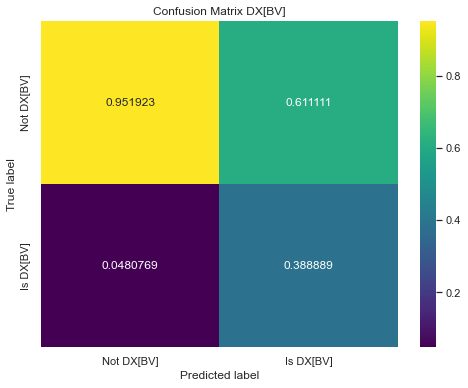

DX[BV]: 0.13788230672522858
True Positives: 8
True Negatives: 93
False Positives: 21
False Negatives: 0


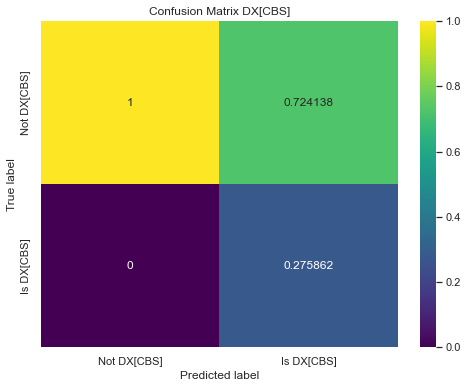

DX[CBS]: 0.0831577194847753
True Positives: 37
True Negatives: 60
False Positives: 21
False Negatives: 4


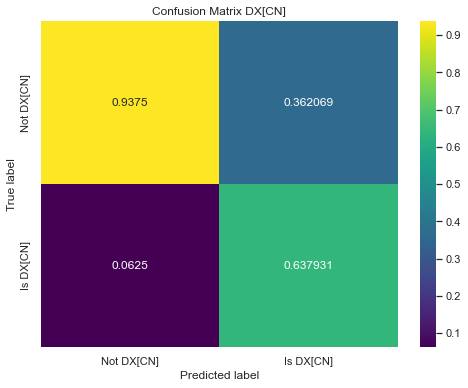

DX[CN]: 0.401201572340124
True Positives: 7
True Negatives: 94
False Positives: 20
False Negatives: 1


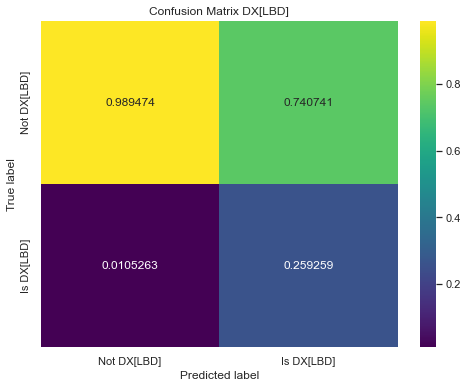

DX[LBD]: 0.08369711850814995
True Positives: 6
True Negatives: 95
False Positives: 19
False Negatives: 2


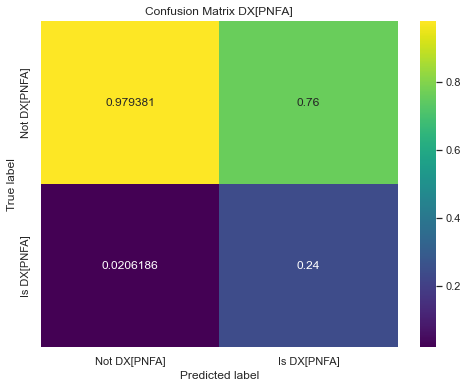

DX[PNFA]: 0.10336461162266221
True Positives: 7
True Negatives: 48
False Positives: 65
False Negatives: 2


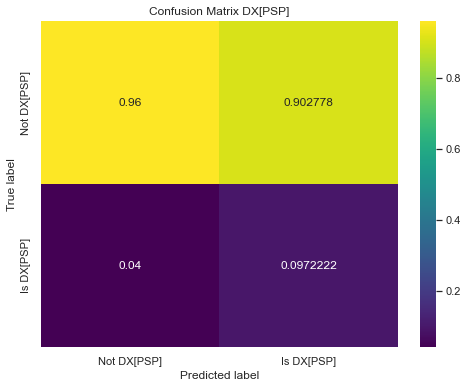

DX[PSP]: 0.05145608552925677
True Positives: 8
True Negatives: 107
False Positives: 7
False Negatives: 0


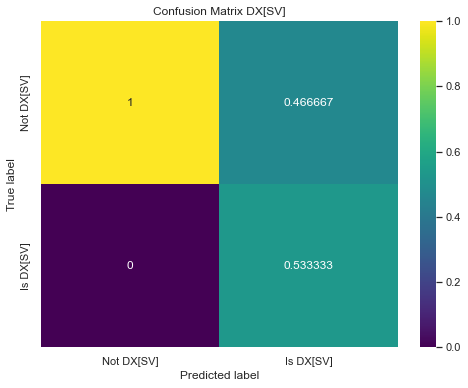

DX[SV]: 0.12680933967188465


In [37]:
from calvin_utils.statistical_utils.classification_statistics import calculate_youden_and_metrics, save_dfs
dfs, youden_dict = calculate_youden_and_metrics(raw_observations=loocv_evaluator.raw_observations, 
                                                raw_predictions=loocv_evaluator.raw_predictions, 
                                                outcome_matrix_cols=loocv_evaluator.outcome_matrix.columns,
                                                out_dir=out_dir+'/metrics_per_diagnosis')
save_dfs(dfs, out_dir=out_dir+'/metrics_per_diagnosis')

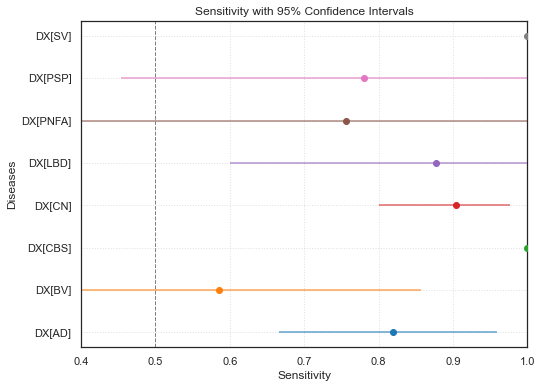

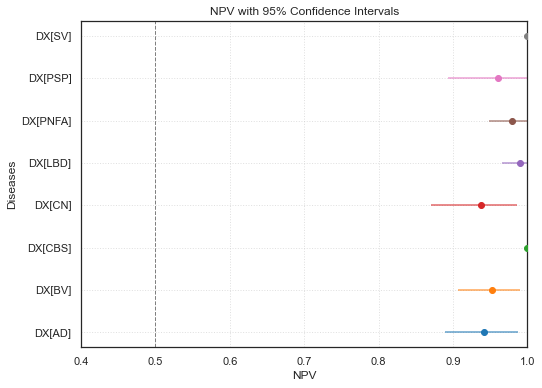

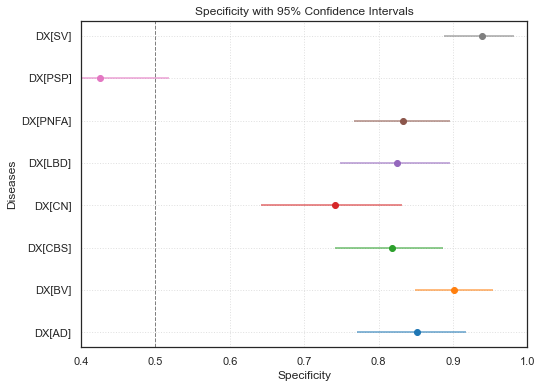

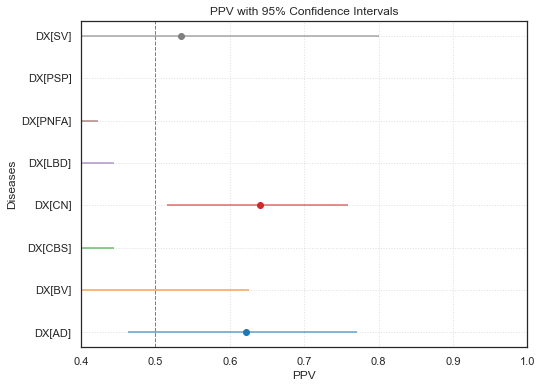

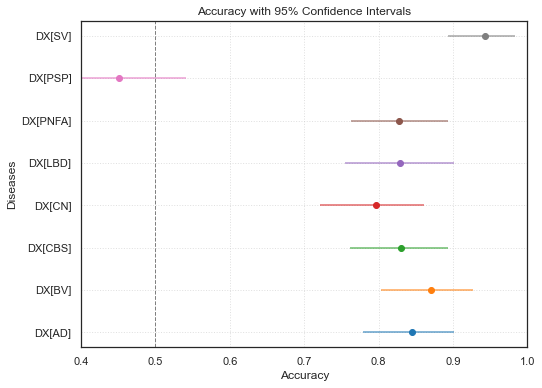

In [39]:
ComprehensiveMulticlassROC.generate_all_plots(dfs, out_dir=out_dir+'/metrics_per_diagnosis')

Get Overall Micro Average AUC

In [40]:
loocv_evaluator.get_micro_auc()

Taking maximum probability as prediction.
There are 28.0 observations for DX[AD]
There are 12.0 observations for DX[BV]
There are 8.0 observations for DX[CBS]
There are 41.0 observations for DX[CN]
There are 8.0 observations for DX[LBD]
There are 8.0 observations for DX[PNFA]
There are 9.0 observations for DX[PSP]
There are 8.0 observations for DX[SV]


0.8787000422313511